<H1>Correlatieonderzoek - Gemeentes</H1>

In [2]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

from pyspark import SparkConf

#Functionality imports
from pyspark.sql import *
from pyspark.sql.types import *
import folium
from IPython.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics

sc = SparkSession.builder.getOrCreate()












+
#Configure to use 4 cores
conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])
sc.stop()
sc = pyspark.SparkContext(conf=conf)

sqlContext = SQLContext(sc)

sqlContext.setConf('spark.sql.shuffle.partitions', '8')

df = sqlContext.sql('''select 'spark' as hello ''')
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



<H2>Inlezen verkiezingsdata</H2>

In [4]:
#Getting data from csv into list, make sure to have the right location for the csv file
election_data = (sc.textFile('../data/verkiezingen/verkiezingen2014VL.csv')).collect()

#making lists from data
lists = []

for line in election_data:
    if line[-1] ==",":
        line = line[:-1]
    if "PartijNummer" in line:
        lists.append(list)
        list = []
        list.append(line)
    if "Groen" in line or "Vlaams Belang" in line or "OpenVld" in line or "sp.a" in line or "N-VA" in line or "CD&V" in line or "PVDA+" in line:
        list.append(line)

#Remove empty lists from lists
lists = [x for x in lists if x != []]

#rowlist
rowlist = []

#Removing unwanted columns
for item in lists:
    #Parsing the rows
    for line in item:
        row = line.split(",")
        del(row[0:2])
        del(row[-1])
        rowlist.append(row)

#Making lists from what are to become the columns of the dataframe
i = -1
list0,list1,list2,list3,list4,list5,list6,list7 = [],[],[],[],[],[],[],[]
for row in rowlist:
    i += 1
    if i == 0:
        for x in row:
            list0.append(x)
    if i == 1:
        for x in row:
            list1.append(x)
    if i == 2:
        for x in row:
            list2.append(x)
    if i == 3:
        for x in row:
            list3.append(x)
    if i == 4:
        for x in row:
            list4.append(x)
    if i == 5:
        for x in row:
            list5.append(x)
    if i == 6:
        for x in row:
            list6.append(x)
    if i == 7:
        i = -1
        for x in row:
            list7.append(x)

rowlist = []
#Making rows for the dataframe
for i in range (0, len(list0)-1):
    row = [list0[i], list1[i], list2[i], list3[i], list4[i], list5[i], list6[i], list7[i]]
    rowlist.append(row)
    
#Making a schema for the dataframe
schema = ["Gemeente","Groen","Vlaams_Belang","OpenVld","sp_a","N_VA","CD_V","PVDA"]

#create the frame
election_df = sqlContext.createDataFrame(rowlist, schema)
election_df.show()

+--------------+-----+-------------+-------+-----+-----+-----+----+
|      Gemeente|Groen|Vlaams_Belang|OpenVld| sp_a| N_VA| CD_V|PVDA|
+--------------+-----+-------------+-------+-----+-----+-----+----+
|      Geetbets|  156|          217|    904|  692| 1257|  786|  63|
|        Linter|  286|          253|    871|  667| 1488| 1348|  72|
|     Zoutleeuw|  257|          298|   1119|  914| 1838| 1215|  90|
|       Avelgem|  413|          296|   1032| 1427| 1555| 1769|  84|
|Spiere-Helkijn|  111|           50|    308|  237|  206|  278|  17|
|       Beernem|  876|          448|   1468| 1360| 3234| 2970| 146|
|  Blankenberge|  693|          903|   2502| 3108| 4200| 2033| 180|
|        Brugge| 9112|         3847|   8623|15883|22058|17436|1475|
|         Damme|  504|          308|   1057|  734| 2594| 2316|  91|
|       Jabbeke|  616|          452|   1026| 1248| 3001| 2731| 104|
|  Knokke-Heist| 1253|          999|   5076| 1966| 9561| 3811| 194|
|      Oostkamp| 1226|          722|   1760| 242

<H2>Verkiezingsresultaten weergeven</H2>

In [5]:
#Get results for a municipality function
def get_results_municipality(municipality):
    election_df.createOrReplaceTempView("tempview")
    query = "SELECT * FROM tempview WHERE Gemeente = '" + municipality + "'"
    mundf = sqlContext.sql(query)
    return mundf
def get_gemeentes():
    election_df.createOrReplaceTempView("tempview")
    query = "SELECT DISTINCT Gemeente FROM tempview"
    gemeentes = sqlContext.sql(query)
    print(gemeentes)
    return gemeentes
lijst_gemeentes = sorted(get_gemeentes().collect(), key=lambda x: x.Gemeente)

DataFrame[Gemeente: string]


In [6]:
#Inputting default value for initial run
inp_muni = "Avelgem"

#Input form in jupyter notebook
form = "<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>Selecteer gemeente:"
form += '<select onchange="set_munivars()" id="muni">'
for e in lijst_gemeentes:
    form += '<option value="' + e.Gemeente + '">' + e.Gemeente + '</option>'
form += '</select></div>'
#form = """
#
#Gemeente: <input type="text" id='muni' value="Avelgem"/><br>
# <button onclick="set_munivars()">Zoek</button> 
#</div>
#"""
#Called function from button onclick
javascript = """
<script type="text/Javascript">
    function set_munivars(){
        var var_name1 = 'inp_muni';
        var var_value1 = document.getElementById('muni').value;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell = IPython.notebook.get_cell(7);
        cell.execute();
        cell = IPython.notebook.get_cell(8);
        cell.execute();
        cell.focus_cell(8);
    }
</script>
"""
#Rendering the html
HTML(form + javascript)

In [16]:
#HTML Search is executed here. PLEASE DO NOT ADD CELLS BEFORE THIS ONE. CRACKY CODE!!
#Call search function for municipality
df = get_results_municipality(inp_muni)
df.show()

+--------+-----+-------------+-------+----+----+----+----+
|Gemeente|Groen|Vlaams_Belang|OpenVld|sp_a|N_VA|CD_V|PVDA|
+--------+-----+-------------+-------+----+----+----+----+
|Kapellen| 1465|         1132|   3057|1449|7049|2374| 447|
+--------+-----+-------------+-------+----+----+----+----+



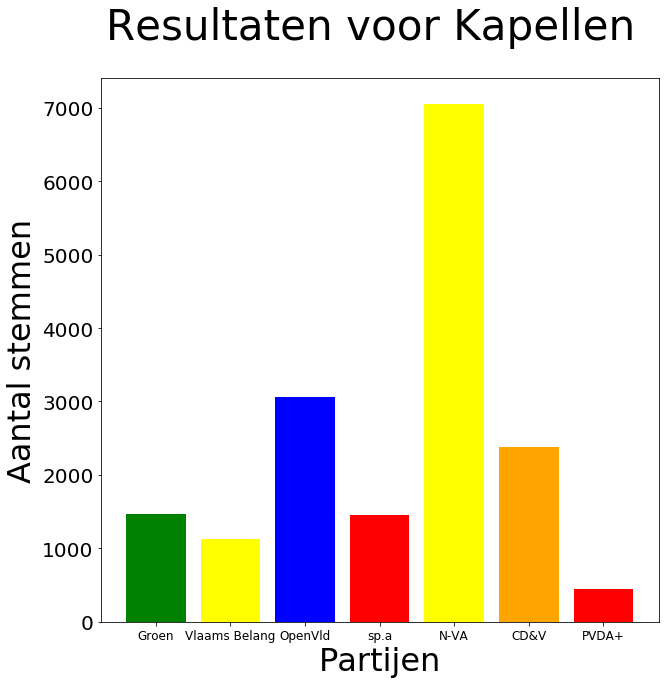

In [17]:
#Giving the x axis the range of the parties & initiating the y_axis valuelist
x_axis = [i+1 for i in range(0,7)]
y_axis=[]

#df -> RDD -> list of values
vals=df.rdd.flatMap(lambda x: x).collect()
#Get municipality name out of here
del(vals[0])

#Vals are interpreted as strings, let's make them ints
for i in vals:
    y_axis.append(int(i))
#Make the figure
fig1 = plt.figure(figsize=(10, 10))
fig1.suptitle('Resultaten voor ' + inp_muni, fontsize=42)
#Add the plot
ax = fig1.add_subplot(111)
ax.set_xlabel('Partijen', fontsize = 32)
ax.set_ylabel('Aantal stemmen', fontsize = 32)
#Actually plot
ax.bar(x_axis, y_axis, align='center', color=['green', 'yellow', 'blue', 'red', 'yellow', 'orange', 'red'])
#Set the x axis tick labels
plt.xticks(x_axis, ["Groen","Vlaams Belang","OpenVld","sp.a","N-VA","CD&V","PVDA+"],fontsize = 12)
#Enlarge them letters
plt.yticks(fontsize = 20)
plt.show()

In [9]:
#Getting data from textfile into list, make sure to have the right location for the text file
name_data = (sc.textFile('../data/verkiezingen/TA_POP_2017.txt')).collect()

#get schema from first line
schema = name_data[0].split('|')

#Get structure line out of file
del(name_data[0])

#make some beautiful rows
rowlist = []
for line in name_data:
        row = line.split("|")
        rowlist.append(row)

#create the frame
name_df = sqlContext.createDataFrame(rowlist, schema)
name_df.show()

+---------+-----------------+-----------------+-----------+------------+
|CD_REFNIS|TX_MUNTY_DESCR_FR|TX_MUNTY_DESCR_NL|TX_FST_NAME|MS_FREQUENCY|
+---------+-----------------+-----------------+-----------+------------+
|    11001|       Aartselaar|       Aartselaar|       Marc|         135|
|    11001|       Aartselaar|       Aartselaar|        Jan|         125|
|    11001|       Aartselaar|       Aartselaar|        Luc|         111|
|    11001|       Aartselaar|       Aartselaar|       Paul|         105|
|    11001|       Aartselaar|       Aartselaar|       Dirk|          99|
|    11001|       Aartselaar|       Aartselaar|      Peter|          90|
|    11001|       Aartselaar|       Aartselaar|    Patrick|          85|
|    11001|       Aartselaar|       Aartselaar|      Jozef|          84|
|    11001|       Aartselaar|       Aartselaar|      Willy|          77|
|    11001|       Aartselaar|       Aartselaar|       Bart|          73|
|    11001|       Aartselaar|       Aartselaar|    

In [10]:
#function for correlation between name and party
def get_munname_df(partyname, firstname):
    #Make temporary dataframe to store joined data from election_df and name_df
    temp_df = election_df.select("Gemeente", partyname).join(name_df.select("TX_MUNTY_DESCR_NL","TX_FST_NAME","MS_FREQUENCY"),election_df.Gemeente == name_df.TX_MUNTY_DESCR_NL)
    
    #SQL Query to get the dataframe for firstname
    temp_df.createOrReplaceTempView("tempview")
    query = "SELECT Gemeente," + partyname + ",TX_FST_NAME,MS_FREQUENCY FROM tempview WHERE TX_FST_NAME = '" + firstname + "'"
    result_df = sqlContext.sql(query)
    
    return result_df

In [11]:
#Function to find the correlation between votes for a party and a first name
def get_corr_value(munname_df):
    #Casting columns to ints, were strings previously
    munname_df = munname_df.withColumn(inp_party, munname_df[inp_party].cast(IntegerType()))
    munname_df = munname_df.withColumn("MS_FREQUENCY", munname_df["MS_FREQUENCY"].cast(IntegerType()))

    #Calling a pyspark native function to calculate the correlation
    corr_value = munname_df.stat.corr(inp_party, 'MS_FREQUENCY')
    return corr_value

In [12]:
#Inputting default value for initial run
inp_party = "Groen"
inp_name = "Jan"
partijen = ["Groen","Vlaams_Belang","OpenVld","sp_a","N_VA","CD_V","PVDA"]

#Input form in jupyter notebook
form = "<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>Selecteer partij:"
form += '<select id="party">'
for e in partijen:
    form += '<option value="' + e + '">' + e + '</option>'
form += '</select>naam:<input type="text" id="name" value="Jan"/><br><button onclick="set_munparvars()">Zoek</button> </div>'
form2 = """

<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Partij: <input type="text" id='party' value="Groen"/><br>
Naam: <input type="text" id='name' value="Jan"/><br>
 <button onclick="set_munparvars()">Zoek</button> 
</div>
"""
#Called function from button onclick
javascript = """
<script type="text/Javascript">
    function set_munparvars(){
        var var_name1 = 'inp_party';
        var var_value1 = document.getElementById('party').value;
        var var_name2 = 'inp_name';
        var var_value2 = document.getElementById('name').value;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var command2 = var_name2 + " = '" + var_value2 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        kernel.execute(command2);
        cell = IPython.notebook.get_cell(13);
        cell.execute();
        cell.focus_cell(13);
    }
</script>
"""
#Rendering the html
HTML(form + javascript)

In [18]:
munname_df = get_munname_df(inp_party, inp_name)
munname_df.show()
corr_value = get_corr_value(munname_df)
print(corr_value)

+------------+-------+-----------+------------+
|    Gemeente|OpenVld|TX_FST_NAME|MS_FREQUENCY|
+------------+-------+-----------+------------+
|      Aalter|   1902|      Filip|          79|
|     Anzegem|   1379|      Filip|          47|
|     Beersel|   2447|      Filip|          25|
|Begijnendijk|   1225|      Filip|          14|
|      Bornem|   1191|      Filip|          29|
|    Borsbeek|    449|      Filip|          17|
|  Brasschaat|   2322|      Filip|          52|
|     Bredene|   1072|      Filip|          34|
|   Dentergem|    579|      Filip|          30|
|  Galmaarden|    948|      Filip|          11|
|       Heers|   1044|      Filip|           9|
|   Herentals|   1710|      Filip|          43|
|     Herzele|   2674|      Filip|          55|
|  Hoegaarden|    921|      Filip|          14|
|   Hoeilaart|   2024|      Filip|          10|
|  Kampenhout|   2028|      Filip|          24|
|    Kruibeke|   1087|      Filip|          50|
|      Kuurne|   1154|      Filip|      

<h2>Lonen onderzoek</h2>

In [19]:
loon_data = (sc.textFile('../data/verkiezingen/loonpergemeente.csv')).collect()

#making table structure
schema = loon_data[0].split(",")
del(loon_data[0])
rowlist = []
for line in loon_data:
        row = line.split(",")
        rowlist.append(row)

salary_df = sqlContext.createDataFrame(rowlist,schema)
salary_df.show()

+--------+----------+----------+-------------+----------+
|Postcode|    Gewest|  Gemeente|Bruto_inkomen|      NAMN|
+--------+----------+----------+-------------+----------+
|    2630|Vlaanderen|Aartselaar|        23250|Aartselaar|
|    2000|Vlaanderen| Antwerpen|        15615| Antwerpen|
|    2530|Vlaanderen|  Boechout|        21490|  Boechout|
|    2850|Vlaanderen|      Boom|        16918|      Boom|
|    2150|Vlaanderen|  Borsbeek|        18745|  Borsbeek|
|    2930|Vlaanderen|Brasschaat|        21714|Brasschaat|
|    2960|Vlaanderen|    Brecht|        19913|    Brecht|
|    2650|Vlaanderen|    Edegem|        22345|    Edegem|
|    2910|Vlaanderen|     Essen|        17825|     Essen|
|    2620|Vlaanderen|  Hemiksem|        18324|  Hemiksem|
|    2540|Vlaanderen|      Hove|        24754|      Hove|
|    2920|Vlaanderen| Kalmthout|        19910| Kalmthout|
|    2950|Vlaanderen|  Kapellen|        21963|  Kapellen|
|    2550|Vlaanderen|   Kontich|        22063|   Kontich|
|    2547|Vlaa

In [20]:
def get_salpar_df(partyname):
    #Make temporary dataframe to store joined data from election_df and name_df
    temp_df = election_df.join(salary_df.select("NAMN","Bruto_inkomen"),election_df.Gemeente == salary_df.NAMN)
    
    #SQL Query to get the dataframe for firstname
    temp_df.createOrReplaceTempView("tempview")
    query = "SELECT Gemeente," + partyname + ",Bruto_inkomen FROM tempview"
    result_df = sqlContext.sql(query)
    
    return result_df

In [21]:
#Function to find the correlation between votes for a party and salary
def get_salparcorr_value(salpar_df):
    #Casting columns to ints, were strings previously
    salpar_df = salpar_df.withColumn(inp_salparty, salpar_df[inp_salparty].cast(IntegerType()))
    salpar_df = salpar_df.withColumn("Bruto_inkomen", salpar_df["Bruto_inkomen"].cast(IntegerType()))

    #Calling a pyspark native function to calculate the correlation
    corr_value = salpar_df.stat.corr(inp_salparty, 'Bruto_inkomen')
    return corr_value

In [22]:
#default value for initial run
inp_salparty = "Groen"

#Input form in jupyter notebook
form = """
<div style='background-color:gainsboro; border:solid black; width:300px; padding:20px;'>
Partij: <input type="text" id='salparty' value="Groen"/><br>
 <button onclick="set_salparvars()">Zoek</button> 
</div>
"""
#Called function from button onclick
javascript = """
<script type="text/Javascript">
    function set_salparvars(){
        var var_name1 = 'inp_salparty';
        var var_value1 = document.getElementById('salparty').value;
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell = IPython.notebook.get_cell(19);
        cell.execute();
        cell.focus_cell(15);
    }
</script>
"""
#Rendering the html
HTML(form + javascript)

# salpar_df = get_salpar_df(inp_salparty)
salpar_df.show()
corr_value = get_salparcorr_value(salpar_df)
print(corr_value)